Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompletePEDBM0/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Epoch 1/5
582/582 [==============================] - 138s 226ms/step - loss: 0.7131 - accuracy: 0.6020 - val_loss: 0.6017 - val_accuracy: 0.6556
Epoch 2/5
582/582 [==============================] - 149s 257ms/step - loss: 0.5785 - accuracy: 0.6870 - val_loss: 0.5178 - val_accuracy: 0.7442
Epoch 3/5
582/582 [==============================] - 150s 258ms/step - loss: 0.4826 - accuracy: 0.7669 - val_loss: 0.4614 - val_accuracy: 0.7803
Epoch 4/5
582/582 [==============================] - 125s 215ms/step - loss: 0.4036 - accuracy: 0.8175 - val_loss: 0.4657 - val_accuracy: 0.7820
Epoch 5/5
582/582 [==============================] - 150s 258ms/step - loss: 0.3259 - accuracy: 0.8634 - val_loss: 0.4479 - val_accuracy: 0.7966


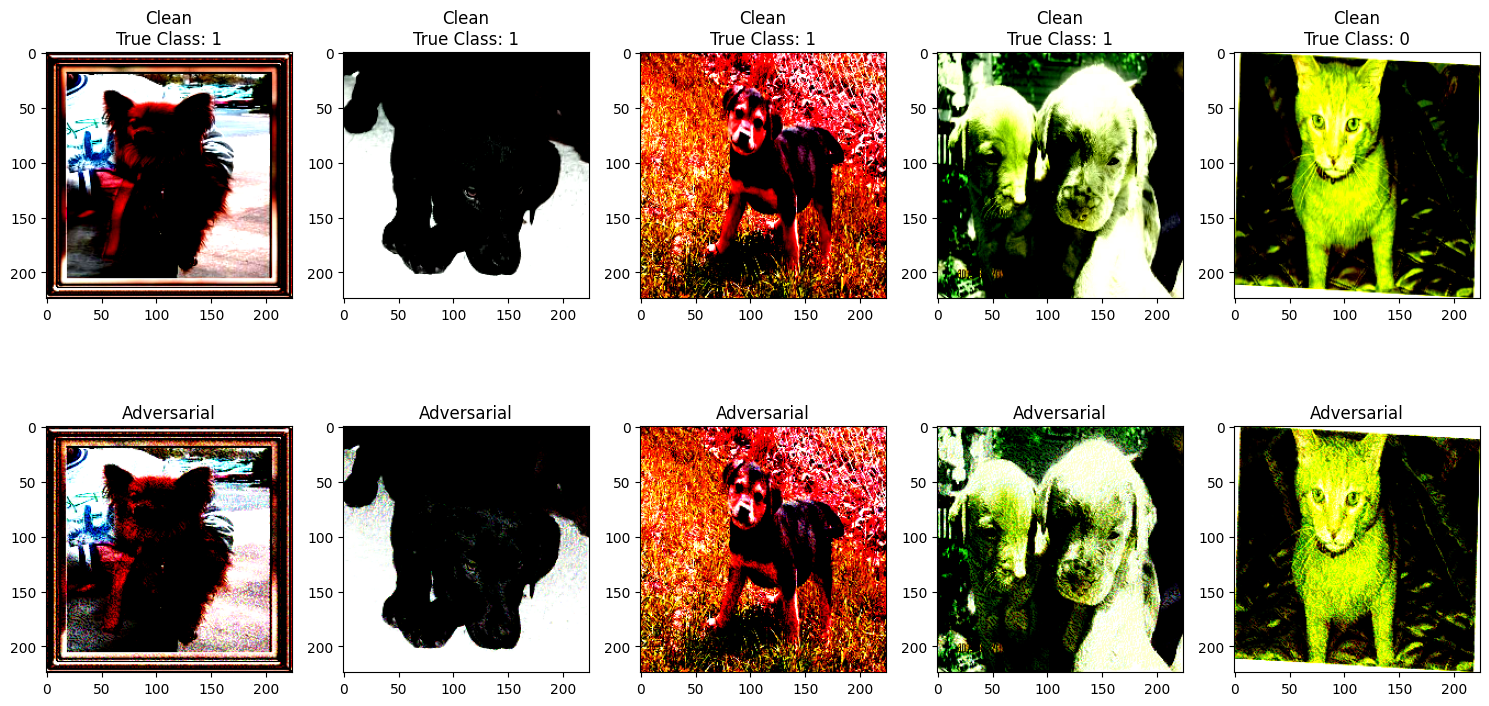

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
dataset, dataset_info = tfds.load('cats_vs_dogs', split='train', with_info=True, as_supervised=True)
num_classes = 2
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.2, upper=1.8)
    image = tf.image.per_image_standardization(image)
    label = tf.one_hot(label, num_classes)
    return image, label
dataset = dataset.map(preprocess_image)
num_samples = dataset_info.splits['train'].num_examples
num_train_samples = int(0.8 * num_samples)
num_val_samples = int(0.1 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples
train_dataset = dataset.take(num_train_samples)
remaining_dataset = dataset.skip(num_train_samples)
val_dataset = remaining_dataset.take(num_val_samples)
test_dataset = remaining_dataset.skip(num_val_samples)
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=5, validation_data=val_dataset)
latent_dim = 100
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='tanh'))
    return model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model
generator = build_generator(latent_dim)
discriminator = build_discriminator((224, 224, 3))
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
attack = FastGradientMethod(estimator=art_classifier, eps=0.2)
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
adversarial_test_images = attack.generate(test_images.numpy(), y=test_labels.numpy())
num_display = min(len(test_images), 5)
plt.figure(figsize=(15, 8))
for i in range(num_display):
    plt.subplot(2, num_display, i + 1)
    plt.imshow(test_images[i])
    plt.title(f'Clean\nTrue Class: {np.argmax(test_labels[i])}')
    plt.subplot(2, num_display, num_display + i + 1)
    plt.imshow(adversarial_test_images[i])
    plt.title('Adversarial')

plt.tight_layout()
plt.show()
  #Here we are looking at the original class and also the predicted class using GAN and ART which allowed to combine them both together, we are able to see that it is sucessfully confusing the AI model.



In [9]:
pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00
